In [1]:
%config Completer.use_jedi = False

import sys
import os
import re
import json

from collections import defaultdict, Counter
import h5py
import pandas as pd
import numpy as np
import scipy.io as sp_io

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from scipy.sparse import csc_matrix, csr_matrix
import scanpy as sc
sc.settings.set_figure_params(dpi=120, facecolor='white')

In [10]:
def read_csc_matrix_h5(h5_file):
    """generic io function for reading sparse matrix h5"""

    with h5py.File(h5_file, "r") as h5in:
        matrix = csc_matrix((h5in["data"], h5in["indices"], h5in["indptr"]), shape=h5in["shape"])

    return matrix

def sum_sparse_matrix(matrix, axis=0):
    """Sum a sparse matrix along an axis."""
    axis_sum = np.asarray(matrix.sum(axis=axis))  # sum along given axis
    max_dim = np.prod(axis_sum.shape)  # get the max dimension
    return axis_sum.reshape((max_dim,))  # reshape accordingly


def normalize_matrix(matrix, use_median=False):
    """depth and log normalize matrix"""
    
    counts_per_bc = sum_sparse_matrix(matrix, axis=0)
    median_counts_per_bc = max(1.0, np.median(counts_per_bc))
    print(median_counts_per_bc)
    if use_median:
        scaling_factors = median_counts_per_bc / np.clip(counts_per_bc, 1.0, None)
    else:
        scaling_factors = 1000 / np.clip(counts_per_bc, 1.0, None)

    # Normalize each barcode's total count by median total count
    m = matrix.copy().astype(np.float64)
    sparsefuncs.inplace_column_scale(m, scaling_factors)

    # Use log counts
    m.data = np.log2(1 + m.data)
    
    return m


## Load data

In [9]:
df_cell_meta = pd.read_csv("data/tcell_metadata.csv")
df_cell_meta["batch"] = df_cell_meta["donor"].apply(lambda val: "donor1234" if val in ["P1", "P2", "P3", "P4"] else "donor5678")
df_cell_meta.head()


,Barcode,lane,cell_bc,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,celltype.l1,celltype.l2,celltype.l3,donor,time,Phase,umap1,umap2,batch
0,L1_AAACCCAAGACATACA,L1,AAACCCAAGACATACA-9,5949,211,5864,1617,CD4 T,CD4 TCM,CD4 TCM_1,P1,7,G1,5.286920,5.635788,donor1234
1,L1_AAACCCACAACTGGTT,L1,AAACCCACAACTGGTT-9,6547,217,5067,1381,CD8 T,CD8 Naive,CD8 Naive,P4,3,S,11.907538,-4.530682,donor1234
2,L1_AAACCCACACGTACTA,L1,AAACCCACACGTACTA-9,3508,207,4786,1890,NK,NK,NK_2,P3,7,G1,2.371758,-8.360968,donor1234
3,L1_AAACCCACAGCATACT,L1,AAACCCACAGCATACT-9,6318,219,6505,1621,CD8 T,CD8 Naive,CD8 Naive,P4,7,G1,12.371468,-5.079568,donor1234
4,L1_AAACCCACATCAGTCA,L1,AAACCCACATCAGTCA-9,5195,213,4332,1633,CD8 T,CD8 TEM,CD8 TEM_1,P3,3,G1,5.819462,-3.657757,donor1234


In [ ]:
# mat = sc.read_10x_h5("/home/liwang/yard/imPACT-SMARTseq/literature_data/seurat_v4_cite-seq/cellranger_reanalyze/seurat_v4_tcells_sample/outs/filtered_feature_bc_matrix.h5", 
#                          gex_only=False)
mat = sc.read_10x_h5("/home/liwang/yard/dataset/seurat_v4_cite-seq/cellranger_reanalyze/fbm.h5",  gex_only=False)

In [16]:
mat_gex = mat[df_cell_meta["cell_bc"][df_cell_meta["celltype.l3"] != "CD8 Naive_2"], mat.var["feature_types"] == "Gene Expression"]
mat_gex.var_names_make_unique()

mat.shape, mat_gex.shape

((87918, 20957), (87628, 20729))

In [17]:
mat_gex.obs = mat_gex.obs.join(df_cell_meta.set_index("cell_bc"))
mat_gex.obs.head()

,Barcode,lane,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,celltype.l1,celltype.l2,celltype.l3,donor,time,Phase,umap1,umap2,batch
AAACCCAAGACATACA-9,L1_AAACCCAAGACATACA,L1,5949,211,5864,1617,CD4 T,CD4 TCM,CD4 TCM_1,P1,7,G1,5.286920,5.635788,donor1234
AAACCCACAACTGGTT-9,L1_AAACCCACAACTGGTT,L1,6547,217,5067,1381,CD8 T,CD8 Naive,CD8 Naive,P4,3,S,11.907538,-4.530682,donor1234
AAACCCACACGTACTA-9,L1_AAACCCACACGTACTA,L1,3508,207,4786,1890,NK,NK,NK_2,P3,7,G1,2.371758,-8.360968,donor1234
AAACCCACAGCATACT-9,L1_AAACCCACAGCATACT,L1,6318,219,6505,1621,CD8 T,CD8 Naive,CD8 Naive,P4,7,G1,12.371468,-5.079568,donor1234
AAACCCACATCAGTCA-9,L1_AAACCCACATCAGTCA,L1,5195,213,4332,1633,CD8 T,CD8 TEM,CD8 TEM_1,P3,3,G1,5.819462,-3.657757,donor1234


#### Phenomarker plate

In [7]:
pheno_meta = pd.read_csv("/home/liwang/yard/active/intergenic_mapping_BIOSC-27_33/pheno_celltype_metadata.csv")
print(pheno_meta.shape)
pheno_meta.head()

(133, 6)


,cell_id,row,col,celltype,broad_celltype,condition
0,EXP043_P05P07_P07-F08_S11,F,8,CD4 T,CD4 T,S239 only
1,EXP211_P08_Pool1_B09_S18,B,9,CD8 central mem,CD8 T,S239 only
2,EXP211_P09_E12_S21,E,12,CD8 naive,CD8 T,S239 only
3,EXP211_P08_Pool2_C05_S14,C,5,CD8 eff mem,CD8 T,spike-in
4,EXP211_P09_E05_S5,E,5,CD8 naive,CD8 T,spike-in


In [8]:
pheno_mat = sc.read_10x_h5("/home/liwang/yard/dataset/EXP0043_pheno/pipeline_out/matrices/star_count_matrix.h5")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
pheno_mat.obs = pheno_mat.obs.join(pheno_meta[["cell_id", "celltype", "broad_celltype"]].set_index("cell_id"))
pheno_mat.obs.head()

,celltype,broad_celltype
EXP043_P05_H11_S13,Macrophage,Macrophage
EXP043_P05_F09_S6,CD4 T,CD4 T
EXP043_P05_A10_S7,CD8 effector,CD8 T
EXP043_P05_C10_S9,CD8 eff mem,CD8 T
EXP043_P05_D11_S12,CD8 stemcell mem,CD8 T


In [10]:
pheno_mat.var_names_make_unique()
pheno_mat.obs_names_make_unique()

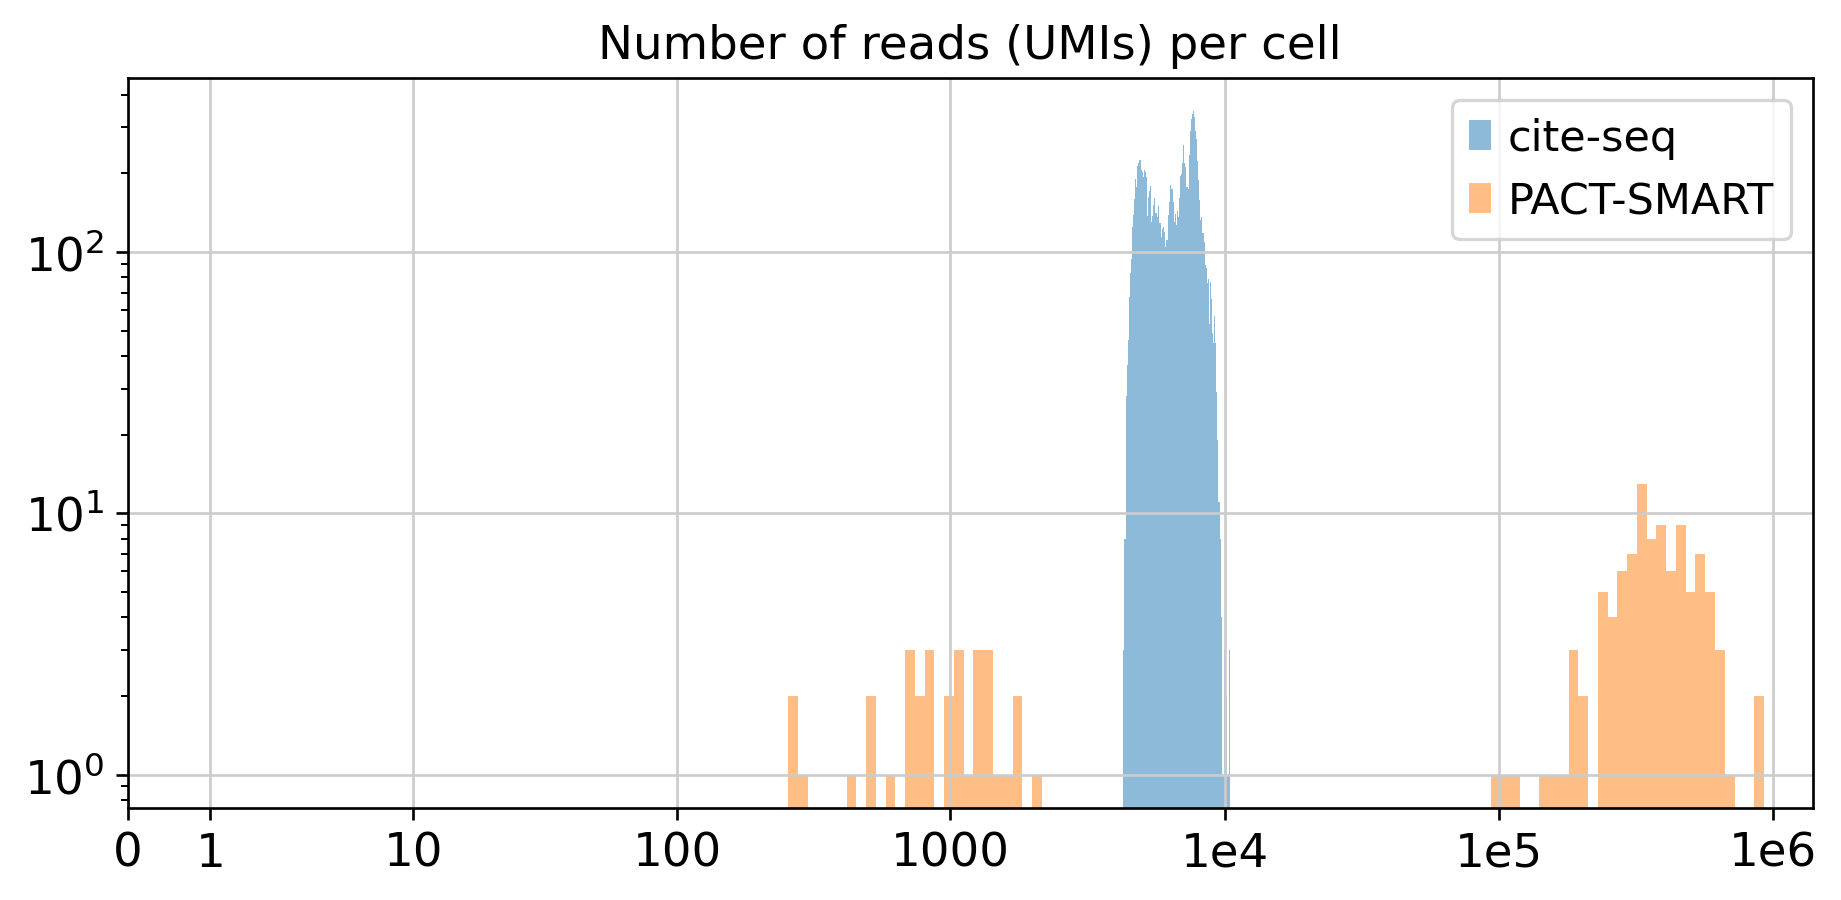

In [11]:
fig = plt.figure(figsize=(9, 4))

p = plt.hist(np.log1p(sum_sparse_matrix(mat_gex.X, axis=1)), 100, alpha=0.5, label="cite-seq")
p = plt.hist(np.log1p(sum_sparse_matrix(pheno_mat.X, axis=1)), 100, alpha=0.5, label="PACT-SMART")

x_labels = [0, 1, 10, 100, 1000, 10000, 1e5, 1e6]
plt.xticks(np.log1p(x_labels), [0, 1, 10, 100, 1000, "1e4", "1e5", "1e6"])

plt.title("Number of reads (UMIs) per cell")
plt.yscale("log")
plt.legend()

#### Filter outlier cells from pheno data

In [12]:
# exclude cells with less than 10000 reads
pheno_filtered = pheno_mat[sum_sparse_matrix(pheno_mat.X, axis=1) > 1e4, :]

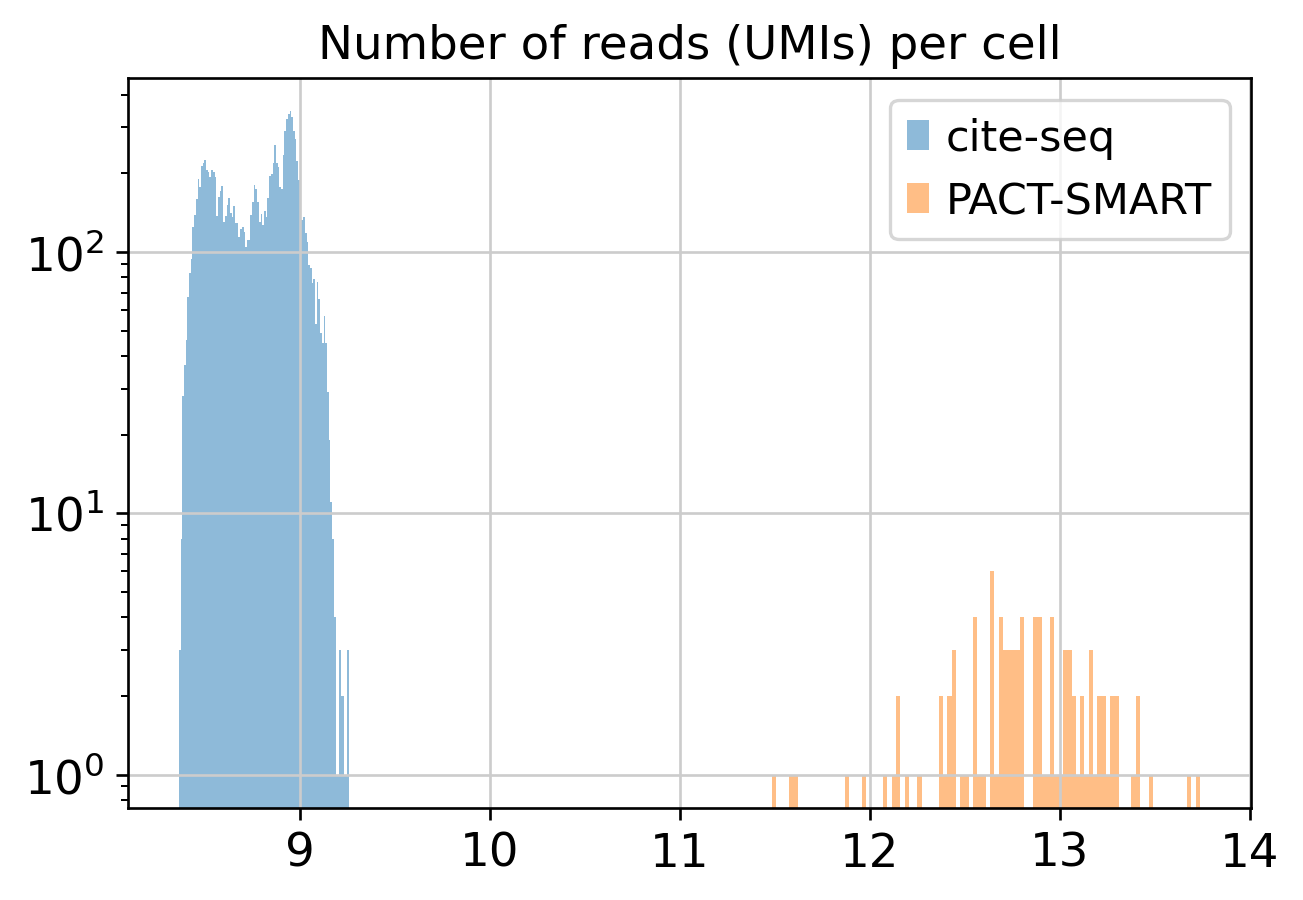

In [13]:
fig = plt.figure(figsize=(6, 4))

p = plt.hist(np.log1p(sum_sparse_matrix(mat_gex.X, axis=1)), 100, alpha=0.5, label="cite-seq")
p = plt.hist(np.log1p(sum_sparse_matrix(pheno_filtered.X, axis=1)), 100, alpha=0.5, label="PACT-SMART")

# x_labels = [0, 1, 10, 100, 1000, 10000, 1e5, 1e6]
# plt.xticks(np.log1p(x_labels), [0, 1, 10, 100, 1000, "1e4", "1e5", "1e6"])

plt.title("Number of reads (UMIs) per cell")
plt.yscale("log")
plt.legend()

## Normalize data


In [18]:
from sklearn.utils import sparsefuncs

In [15]:
def run_scanpy_basic(adata, n_top_highvar=5000):
    normed = adata.copy()
    sc.pp.normalize_total(normed, target_sum=10000)
    sc.pp.log1p(normed)
    
    if n_top_highvar:
        sc.pp.highly_variable_genes(normed, min_disp=0.3,inplace=True, n_top_genes=n_top_highvar)
        
    sc.pp.scale(normed, max_value=10)
    
    return normed

In [16]:
common_genes = set(pheno_mat.var.index).intersection(set(mat_gex.var.index))
common_genes = sorted(list(common_genes))

seurat_filtered = mat_gex[:, common_genes]
pheno_filtered = pheno_filtered[:, common_genes]
seurat_filtered.shape, pheno_filtered.shape

((13340, 20177), (101, 20177))

In [17]:
seurat_norm = run_scanpy_basic(seurat_filtered, n_top_highvar=2000)
pheno_norm = run_scanpy_basic(pheno_filtered, n_top_highvar=None)

seurat_norm.shape, pheno_norm.shape

((13340, 20177), (101, 20177))

#### Use highly variable genes from cite-seq

In [18]:
higgvar_genes = seurat_norm.var.index[seurat_norm.var["highly_variable"]]

seurat_hivar = seurat_norm[:, higgvar_genes]
pheno_hivar = pheno_norm[:, higgvar_genes]
seurat_hivar.shape, pheno_hivar.shape

((13340, 2000), (101, 2000))

In [19]:
higgvar_genes

Index(['A1BG', 'AARD', 'ABAT', 'ABCA5', 'ABCB1', 'ABHD2', 'ABI3', 'AC002116.2',
       'AC002310.1', 'AC002347.1',
       ...
       'ZNF793', 'ZNF80', 'ZNF829', 'ZNF831', 'ZNF836', 'ZNF844', 'ZNF99',
       'ZRSR2', 'ZSCAN16-AS1', 'ZWINT'],
      dtype='object', length=2000)

,celltype,broad_celltype
EXP043_P05_H11_S13,Macrophage,Macrophage
EXP043_P05_F09_S6,CD4 T,CD4 T
EXP043_P05_A10_S7,CD8 effector,CD8 T
EXP043_P05_C10_S9,CD8 eff mem,CD8 T
EXP043_P05_D11_S12,CD8 stemcell mem,CD8 T
...,...,...
EXP211_P09_D05_S4,CD8 stemcell mem,CD8 T
EXP211_P09_C11_S16,CD8 eff mem,CD8 T
EXP211_P09_A12_S18,CD8 effector,CD8 T
EXP211_P09_E06_S10,CD8 naive,CD8 T


## Train classifiers

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn import svm

from joblib import parallel_backend


In [21]:
# Multi-class
X = seurat_hivar.X
y = mat_gex.obs["celltype.l1"].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8004, 2000), (8004,), (5336, 2000), (5336,))

In [124]:
%%time

# Fitting (1min 25s)

models = {
   "SVM": svm.LinearSVC(C=0.001, random_state=0),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=0),
    "Logistic": LogisticRegression(penalty="l1", solver="saga", C=0.01, random_state=0)
}

cali_svm = CalibratedClassifierCV()

with parallel_backend('threading', n_jobs=4):
    for label, model in models.items():
        print("Fitting {}...".format(label))
        model.fit(X_train, y_train)

        if label == "SVM":
            print("Fitting calibrated SVM...")
            cali_svm = CalibratedClassifierCV(model, cv=3, method='sigmoid').fit(X_train, y_train)

    models["Calib_SVM"] = cali_svm

Fitting SVM...
Fitting calibrated SVM...
Fitting RandomForest...
Fitting Logistic...
CPU times: user 1min 30s, sys: 14.6 s, total: 1min 44s
Wall time: 1min 7s


/home/liwang/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [127]:
# Output prediction probabilities

df_prob = []
for label, model in models.items():
    print("{}: {}".format(label, model.score(X_test, y_test)))
    
    if label == "SVM":
        continue
    
    prob = pd.DataFrame(model.predict_proba(pheno_hivar.X), columns=model.classes_, index=pheno_hivar.obs.index)
    prob["model"] = label
    df_prob.append(prob)
    
df_prob = pd.concat(df_prob, axis=0).reset_index()\
    .merge(pheno_hivar.obs.reset_index(), on="index")\
    .rename(columns={'index': 'cell_id'})
    
df_prob.head(12)

SVM: 0.9767616191904048
RandomForest: 0.9752623688155923
Logistic: 0.9700149925037481
Calib_SVM: 0.9791979010494752


,cell_id,CD4 T,CD8 T,NK,model,celltype,broad_celltype
0,EXP043_P05_H11_S13,0.540000,0.246667,0.213333,RandomForest,Macrophage,Macrophage
1,EXP043_P05_H11_S13,0.804344,0.005759,0.189897,Logistic,Macrophage,Macrophage
2,EXP043_P05_H11_S13,0.506119,0.000003,0.493879,Calib_SVM,Macrophage,Macrophage
3,EXP043_P05_F09_S6,0.793333,0.200000,0.006667,RandomForest,CD4 T,CD4 T
4,EXP043_P05_F09_S6,0.985776,0.010313,0.003911,Logistic,CD4 T,CD4 T
5,EXP043_P05_F09_S6,0.978264,0.000692,0.021045,Calib_SVM,CD4 T,CD4 T
6,EXP043_P05_A10_S7,0.263333,0.713333,0.023333,RandomForest,CD8 effector,CD8 T
7,EXP043_P05_A10_S7,0.149789,0.810584,0.039627,Logistic,CD8 effector,CD8 T
8,EXP043_P05_A10_S7,0.003056,0.995454,0.001490,Calib_SVM,CD8 effector,CD8 T
9,EXP043_P05_C10_S9,0.183333,0.730000,0.086667,RandomForest,CD8 eff mem,CD8 T


### Make consensus prediction
For each model, $$consensus = \frac{\sum (weight * top~prediction)}{\sum weight}$$ 

where $$weight = top1~prob - top2~prob$$
and $$confidence = mean( weights ) $$

In [166]:
import operator
from scipy.stats import rankdata

In [290]:
df_consensus = []
for cell_id, data in df_prob.groupby("cell_id"):
    pred_mat = np.array(data.iloc[:, 1:4])
    rank2 = pred_mat[rankdata(-pred_mat, axis=1) == 2][:, np.newaxis]
    pred_confs = np.clip(pred_mat - rank2, 0, 1).mean(axis=0)
    
    index, pred_conf = max(enumerate(pred_confs), key=operator.itemgetter(1))
    df_consensus.append([cell_id, model.classes_[index], pred_conf])

df_consensus = pd.DataFrame(df_consensus, columns=["cell_id", "pred_cons", "pred_conf"])
df_consensus = pheno_hivar.obs.join(df_consensus.set_index("cell_id"))
df_consensus.head()

,celltype,broad_celltype,pred_cons,pred_conf
EXP043_P05_H11_S13,Macrophage,Macrophage,CD4 T,0.306673
EXP043_P05_F09_S6,CD4 T,CD4 T,CD4 T,0.842005
EXP043_P05_A10_S7,CD8 effector,CD8 T,CD8 T,0.701064
EXP043_P05_C10_S9,CD8 eff mem,CD8 T,CD8 T,0.828267
EXP043_P05_D11_S12,CD8 stemcell mem,CD8 T,CD8 T,0.660360


In [ ]:
#### Output prediction probabilities

df_feat_imp = []
for label, model in models.items():
    
    if label in ["Calib_SVM", "RandomForest"]:
        continue
    
    feat_imp = pd.DataFrame(model.coef_.T, columns=model.classes_, index=higgvar_genes)
    feat_imp["model"] = label
    feat_imp["rf"] = models["RandomForest"].feature_importances_
    df_feat_imp.append(feat_imp)
    
df_feat_imp = pd.concat(df_feat_imp, axis=0).reset_index()\
    .rename(columns={'index': 'feature'})

In [130]:
df_feat_imp.query("feature == 'CD4'")

,feature,CD4 T,CD8 T,NK,model,rf
439,CD4,0.164721,-0.119846,-0.007177,SVM,0.018597
2439,CD4,0.433273,-0.050378,0.000000,Logistic,0.018597


## Export models and results

In [135]:
import pickle

In [133]:
models

{'SVM': LinearSVC(C=0.001, random_state=0),
 'RandomForest': RandomForestClassifier(n_estimators=300, random_state=0),
 'Logistic': LogisticRegression(C=0.01, penalty='l1', random_state=0, solver='saga'),
 'Calib_SVM': CalibratedClassifierCV(base_estimator=LinearSVC(C=0.001, random_state=0), cv=3)}

In [136]:
# save the classifier
with open('l1_classifier_2khivar.pkl', 'wb') as fid:
    pickle.dump(models, fid)    

In [137]:
# load it again
# with open('l1_classifier_2khivar.pkl', 'rb') as fid:
#     l1_model = pickle.load(fid)

In [143]:
df_prob.to_csv("pheno_l1_pred.csv", index=False)
df_prob.head(12)

,cell_id,CD4 T,CD8 T,NK,model,celltype,broad_celltype
0,EXP043_P05_H11_S13,0.540000,0.246667,0.213333,RandomForest,Macrophage,Macrophage
1,EXP043_P05_H11_S13,0.804344,0.005759,0.189897,Logistic,Macrophage,Macrophage
2,EXP043_P05_H11_S13,0.506119,0.000003,0.493879,Calib_SVM,Macrophage,Macrophage
3,EXP043_P05_F09_S6,0.793333,0.200000,0.006667,RandomForest,CD4 T,CD4 T
4,EXP043_P05_F09_S6,0.985776,0.010313,0.003911,Logistic,CD4 T,CD4 T
5,EXP043_P05_F09_S6,0.978264,0.000692,0.021045,Calib_SVM,CD4 T,CD4 T
6,EXP043_P05_A10_S7,0.263333,0.713333,0.023333,RandomForest,CD8 effector,CD8 T
7,EXP043_P05_A10_S7,0.149789,0.810584,0.039627,Logistic,CD8 effector,CD8 T
8,EXP043_P05_A10_S7,0.003056,0.995454,0.001490,Calib_SVM,CD8 effector,CD8 T
9,EXP043_P05_C10_S9,0.183333,0.730000,0.086667,RandomForest,CD8 eff mem,CD8 T


In [145]:
df_feat_imp.to_csv("pheno_l1_featcoef.csv", index=False)

df_feat_imp.head()

,feature,CD4 T,CD8 T,NK,model,rf
0,A1BG,-0.044506,0.042162,0.007376,SVM,0.001688
1,AARD,0.009033,0.006977,0.003265,SVM,0.000000
2,ABAT,0.004926,-0.006486,-0.006362,SVM,0.000069
3,ABCA5,-0.000147,-0.001697,-0.000548,SVM,0.000180
4,ABCB1,-0.030223,0.017356,-0.005459,SVM,0.000210


In [294]:
df_consensus.index.name = "cell_id"
df_consensus.to_csv("pheno_l1_pred_consensus.csv")
